# Energy consumption of top 100 crypto

In [77]:
# Import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [78]:
DATA_PATH = 'data/'
HIST_PATH = DATA_PATH + 'hist/'
HARDWARE_PATH = DATA_PATH+'hardware/'

In [79]:
mineable_100 = pd.read_csv(HIST_PATH+'mineable_100_03-29-2020.csv')
mineable_100 = mineable_100.set_index('Name')

In [80]:
mineable_100[:10]

,#,market_cap,price,tag,algorithm,block_time,difficulty,nethash_scraped,block_reward,exchange_rate,exchange_rate_curr
Name,,,,,,,,,,,
bitcoin,1,"$112,637,095,947","$6,157.28",BTC,SHA-256,628.0000,1.391252e+13,9.514942e+19,12.681600,6122.690000,BTC
ethereum,2,"$14,302,393,217",$129.67,ETH,Ethash,13.2139,2.241400e+15,1.696244e+14,2.000000,0.021066,BTC
bitcoincash,3,"$3,901,231,254",$212.52,BCH,SHA-256,600.0000,5.402468e+11,0.000000e+00,NaN,NaN,NaN
bitcoinsv,4,"$2,858,475,679",$155.74,BSV,SHA-256,585.0000,3.485503e+11,2.558995e+18,12.500000,0.025320,BTC
litecoin,5,"$2,474,367,059",$38.43,LTC,Scrypt,140.0000,4.894266e+06,1.501480e+14,12.500000,0.006253,BTC
monero,6,"$804,523,074",$45.97,XMR,RandomX,110.0000,1.578298e+11,1.434817e+09,1.801793,0.007469,BTC
cardano,7,"$764,962,992",$0.029504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tron,8,"$749,038,292",$0.011233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dash,9,"$603,611,050",$64.17,DASH,X11,158.0000,1.529665e+08,4.158139e+15,1.553313,0.010452,BTC


In [81]:
# Clean market cap and price
def clean_int(string):
    return float(string.strip('$').replace(',',''))
mineable_100['market_cap'] = mineable_100['market_cap'].apply(lambda x:clean_int(x))    
mineable_100['price'] = mineable_100['price'].apply(lambda x:clean_int(x))

## Hardware based estimation

In this section we make a first estimation based on the most efficient hardware (found online)

In [82]:
found_data = mineable_100[~mineable_100.isnull().any(axis=1)].copy()
found_data

,#,market_cap,price,tag,algorithm,block_time,difficulty,nethash_scraped,block_reward,exchange_rate,exchange_rate_curr
Name,,,,,,,,,,,
bitcoin,1,1.126371e+11,6157.280000,BTC,SHA-256,628.0000,1.391252e+13,9.514942e+19,12.681600,6.122690e+03,BTC
ethereum,2,1.430239e+10,129.670000,ETH,Ethash,13.2139,2.241400e+15,1.696244e+14,2.000000,2.106649e-02,BTC
bitcoinsv,4,2.858476e+09,155.740000,BSV,SHA-256,585.0000,3.485503e+11,2.558995e+18,12.500000,2.532000e-02,BTC
litecoin,5,2.474367e+09,38.430000,LTC,Scrypt,140.0000,4.894266e+06,1.501480e+14,12.500000,6.252700e-03,BTC
monero,6,8.045231e+08,45.970000,XMR,RandomX,110.0000,1.578298e+11,1.434817e+09,1.801793,7.469000e-03,BTC
dash,9,6.036110e+08,64.170000,DASH,X11,158.0000,1.529665e+08,4.158139e+15,1.553313,1.045151e-02,BTC
ethereumclassic,10,5.829628e+08,5.010000,ETC,Ethash,13.0344,1.307509e+14,1.003122e+13,3.104000,8.164000e-04,BTC
zcash,11,2.870108e+08,29.890000,ZEC,Equihash,75.0000,4.411493e+07,4.818527e+09,5.000000,4.852330e-03,BTC
dogecoin,12,2.193462e+08,0.001770,DOGE,Scrypt,62.0000,2.369565e+06,1.641485e+14,10000.000000,2.887500e-07,BTC


In [83]:
found_data['algorithm'].value_counts()

Scrypt              5
SHA-256             4
Equihash            3
Ethash              2
BCD                 1
BeamHashII          1
Ubqhash             1
CryptoNight         1
CuckooCycle         1
NeoScrypt           1
X16Rv2              1
MTP                 1
ZelHash             1
Blake (14r)         1
Zhash               1
Groestl             1
Equihash (210,9)    1
Lyra2REv3           1
X11                 1
RandomX             1
Lyra2REv2           1
Keccak              1
Name: algorithm, dtype: int64

In [84]:
bitcoin_forks = ['bitcoin', 'bitcoinsv', 'bitcoincash','bitcoinsv','peercoin', 'litecoincash']

In [85]:
# Functions to go from the nBits to the first hashrate
def hex_to_bits(hex_number):
    if int(hex_number,16) >= 8:
        return 0
    elif int(hex_number,16) >= 4:
        return 1
    elif int(hex_number,16) >= 2:
        return 2
    elif int(hex_number,16) == 1:
        return 3
    else:
        return 4
        
def nBits_to_factor(nBits):
    if nBits[:2] != "0x":
        raise Exception("Wrong format, provide hexadecimal number")
    exp = 8*(int(nBits[:4],16)-3)
    mantisse = nBits[4:]
    i=0
    extra_0 = 0
    while hex_to_bits(mantisse[i]) == 4:
        extra_0 += 4
        i += 1
    extra_0 += hex_to_bits(mantisse[i])
    return 256-exp-4*len(mantisse)+extra_0
nBits_to_factor("0x200f0f0f")

4

In [133]:
def difficulty_factor(coin):
    """
    Enter the difficulty factors used to calculate current hashrate. 
    These values where all found by exploring the first block, documentation or source code.
    """
    if coin.name in bitcoin_forks:
        return 2**32
    if coin.name == 'zcash':
        return 2**13
    if coin.name == 'litecoin' or coin.name == 'monacoin':
        return 2**32
    if coin.name == 'ethereum' or coin.name == 'ethereumclassic':
        return 1
    if coin.name == 'monero':
        return 1 # https://github.com/monero-project/monero/blob/36241552b56b156c08319935baf7afda12deb3c5/src/cryptonote_basic/difficulty.h
    if coin.name == 'dash' or coin.name == 'dogecoin':
        return 2**20
    if coin.name == 'ravencoin':
        return 2**24
    if coin.name == 'horizen':
        return 2**nBits_to_factor("0x1f07ffff")
    if coin.name == 'komodo':
        return 2**nBits_to_factor("0x200f0f0f")
    else:
        return 0

In [134]:
def hardware_hashrate(coin): # Max hashes per second for the hardware
    if coin['algorithm'] == 'SHA-256':
        return 16*10**12
    if coin['algorithm'] == 'Scrypt':
        return 504*10**6
    if coin['algorithm'] == 'Ethash':
        return 190*10**6
    if coin['algorithm'] == 'Equihash':
        return 42*10**3
    return 0

In [135]:
# Energy use in Watts
def hardware_consumption(coin): 
    if coin['algorithm'] == 'SHA-256':
        return 1280
    if coin['algorithm'] == 'Scrypt':
        return 970
    if coin['algorithm'] == 'Ethash':
        return 800
    if coin['algorithm'] == 'Equihash':
        return 760
    return 0

In [136]:
def hardware_consumption_hash(coin): # Joule per hash
    if coin['algorithm'] == 'SHA-256':
        return 0.1/(10**9)
    if coin['algorithm'] == 'Scrypt':
        return 1.6/(10**6) # Antminer L3+ https://www.asicminervalue.com/miners/bitmain/antminer-l3-504mh
    if coin['algorithm'] == 'Ethash':
        return 4/(10**6) # Bitmain Antminer E3 – Ethereum 190 MH/S
    else: 
        return 0

In [137]:
def calc_num_hardware(coin):
    if coin['hardware_hashrate'] == 0:
        return 0
    if coin['nethash_calc'] != 0:
        return coin['nethash_calc']/coin['hardware_hashrate'] 
    else:
        return coin['nethash_scraped']/coin['hardware_hashrate']

In [138]:
found_data['difficulty_factor'] = found_data.apply(lambda x: difficulty_factor(x), axis=1)
found_data['hardware_hashrate'] = found_data.apply(lambda x: hardware_hashrate(x), axis=1)
found_data['hardware_consumption'] = found_data.apply(lambda x: hardware_consumption(x), axis=1)

In [139]:
found_data['nethash_calc'] = found_data['difficulty']*found_data['difficulty_factor']/found_data['block_time'] # amount of hashes per second
found_data['num_hardware'] = found_data.apply(lambda x: calc_num_hardware(x),axis=1)
found_data['energy_per_second'] = found_data['num_hardware']*found_data['hardware_consumption'] # in Watt
found_data['annual_energy'] = found_data['energy_per_second']*8760 # hours in a year
found_data

,#,market_cap,price,tag,algorithm,block_time,difficulty,nethash_scraped,block_reward,exchange_rate,exchange_rate_curr,difficulty_factor,hardware_hashrate,hardware_consumption,nethash_calc,num_hardware,energy_per_second,annual_energy
Name,,,,,,,,,,,,,,,,,,
bitcoin,1,1.126371e+11,6157.280000,BTC,SHA-256,628.0000,1.391252e+13,9.514942e+19,12.681600,6.122690e+03,BTC,4294967296,16000000000000,1280,9.514942e+19,5.946839e+06,7.611954e+09,6.668071e+13
ethereum,2,1.430239e+10,129.670000,ETH,Ethash,13.2139,2.241400e+15,1.696244e+14,2.000000,2.106649e-02,BTC,1,190000000,800,1.696244e+14,8.927599e+05,7.142079e+08,6.256462e+12
bitcoinsv,4,2.858476e+09,155.740000,BSV,SHA-256,585.0000,3.485503e+11,2.558995e+18,12.500000,2.532000e-02,BTC,4294967296,16000000000000,1280,2.558995e+18,1.599372e+05,2.047196e+08,1.793344e+12
litecoin,5,2.474367e+09,38.430000,LTC,Scrypt,140.0000,4.894266e+06,1.501480e+14,12.500000,6.252700e-03,BTC,4294967296,504000000,970,1.501480e+14,2.979126e+05,2.889752e+08,2.531423e+12
monero,6,8.045231e+08,45.970000,XMR,RandomX,110.0000,1.578298e+11,1.434817e+09,1.801793,7.469000e-03,BTC,1,0,0,1.434817e+09,0.000000e+00,0.000000e+00,0.000000e+00
dash,9,6.036110e+08,64.170000,DASH,X11,158.0000,1.529665e+08,4.158139e+15,1.553313,1.045151e-02,BTC,1048576,0,0,1.015171e+12,0.000000e+00,0.000000e+00,0.000000e+00
ethereumclassic,10,5.829628e+08,5.010000,ETC,Ethash,13.0344,1.307509e+14,1.003122e+13,3.104000,8.164000e-04,BTC,1,190000000,800,1.003122e+13,5.279588e+04,4.223671e+07,3.699935e+11
zcash,11,2.870108e+08,29.890000,ZEC,Equihash,75.0000,4.411493e+07,4.818527e+09,5.000000,4.852330e-03,BTC,8192,42000,760,4.818527e+09,1.147268e+05,8.719239e+07,7.638054e+11
dogecoin,12,2.193462e+08,0.001770,DOGE,Scrypt,62.0000,2.369565e+06,1.641485e+14,10000.000000,2.887500e-07,BTC,1048576,504000000,970,4.007531e+10,7.951450e+01,7.712907e+04,6.756506e+08


In [93]:
total_energy_crypto = np.sum(found_data['annual_energy'])
total_energy_crypto_TWh = total_energy_crypto/10**12
total_energy_crypto_TWh

79.39009751714966

In [94]:
total_energy_world_TWh = 19504 # TWh 

In [95]:
total_energy_crypto_TWh/total_energy_world_TWh

0.004070452087630725

0.4% of global electricity

### Hardware profitability threshold

Here we make our estimation more accurate by investigating entire hardware datasets (created in hardware.ipynb).

In [111]:
def is_profitable(coin, hardware):
    reward_per_sec = coin['price']*coin['block_reward']/coin['block_time']
    rev = reward_per_sec/coin['nethash_calc'] #$/h
    cost = 0.05/(10**3*3600) # $/J
    profitability_threshold = rev/cost
    # consumption is J/h, if smaller, more efficient
    if hardware['consumption'] < profitability_threshold:
        return True
    else:
        return False

In [124]:
def create_profitable_set(coin):
    if coin.algorithm in algorithm_hardware:
        hardware = algorithm_hardware[coin.algorithm]
        hardware.apply(lambda x: is_profitable(coin,x),axis=1)
        return hardware[hardware.apply(lambda x: is_profitable(coin,x),axis=1)]
    return 0

In [160]:
SHA256_hardware = pd.read_csv(HARDWARE_PATH+'SHA256_hardware_clean.csv',index_col=0)
ethash_hardware = pd.read_csv(HARDWARE_PATH+'ethash_hardware_clean.csv',index_col=0)
equihash_hardware = pd.read_csv(HARDWARE_PATH+'equihash_hardware_clean.csv',index_col=0)

# Create dict of algorithms with their hardware
algorithm_hardware = {'SHA-256':SHA256_hardware,'Ethash':ethash_hardware, 'Equihash':equihash_hardware}

In [161]:
# Create dictionairy that maps coins to their profitable hardware
coin_prof_hardware_dict = dict(found_data.apply(lambda x: create_profitable_set(x), axis = 1))
coin_prof_hardware_dict['zcash']

,brand,name,hashing_power,power,cost,efficiency,consumption


### Extrapollation of energy use of other crypto coins

What percent of crypto market cap is represented in the dataset?

In [72]:
found_market_cap = found_data['market_cap'].sum()
top100_market_cap = mineable_100['market_cap'].sum()
total_market_cap =  186318558825 #https://coinmarketcap.com/charts/
print(f'The webscrabed data represents {round(found_market_cap/top100_market_cap,3)*100}% of the market cap of the top 100, and {round(found_market_cap/total_market_cap,3)*100}% of the total market cap')

The webscrabed data represents 95.39999999999999% of the market cap of the top 100, and 72.7% of the total market cap


In [73]:
found_manual_market_cap = found_missing_difficulty['market_cap'].sum()
print(f'The manual data represents {round(found_manual_market_cap/top100_market_cap,3)*100}% of the market cap of the top 100, and {round(found_manual_market_cap/total_market_cap,3)*100}% of the total market cap')

The manual data represents 95.0% of the market cap of the top 100, and 72.5% of the total market cap


In [43]:
found_missing_difficulty = found_data[found_data['difficulty_factor']!=0]
found_data_energy = found_data[found_data['annual_energy'] != 0]

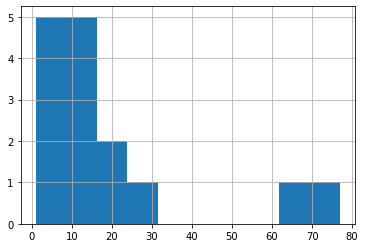

In [44]:
found_data[found_data['difficulty_factor'] != 0]['#'].hist(bins=10)
plt.show()

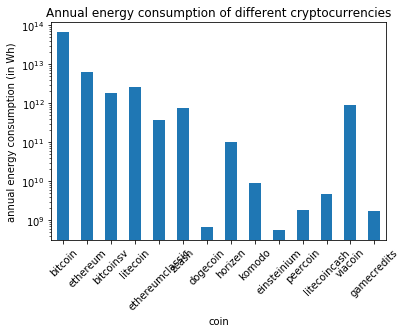

In [31]:
found_data_energy['annual_energy'].plot(kind='bar')
plt.yscale('log')
plt.xticks(rotation=45)
plt.ylabel('annual energy consumption (in Wh)')
plt.xlabel('coin')
plt.title('Annual energy consumption of different cryptocurrencies')
plt.show()

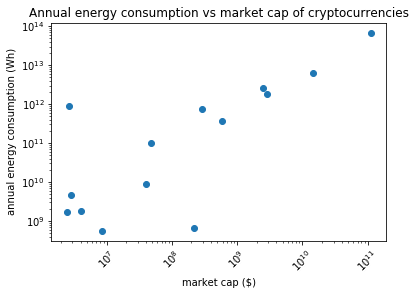

In [32]:
plt.scatter(found_data_energy['market_cap'],found_data_energy['annual_energy'])
plt.yscale('log')
plt.ylabel('annual energy consumption (Wh)')
plt.xscale('log')
plt.xlabel('market cap ($)')
plt.xticks(rotation=45)
plt.title('Annual energy consumption vs market cap of cryptocurrencies')
plt.show()

In [37]:
cdict= {'Equihash':'blue', 'Ethash':'grey','Lyra2REv2':'green','RandomX':'black','SHA-256':'red','Scrypt':'orange','X11':'lightgreen','X16Rv2':'purple'}
cmap = nethash_calc['algorithm'].apply(lambda x: cdict[x])

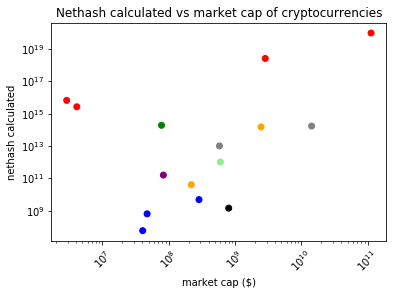

In [38]:
nethash_calc = found_data[found_data['nethash_calc'] != 0].sort_values(by='algorithm')
plt.scatter(nethash_calc['market_cap'],nethash_calc['nethash_calc'],c=cmap,label=nethash_calc['algorithm'])
plt.yscale('log')
plt.ylabel('nethash calculated')
plt.xscale('log')
plt.xlabel('market cap ($)')
plt.xticks(rotation=45)
plt.title('Nethash calculated vs market cap of cryptocurrencies')
plt.show()

## Revenue based estimation

In [147]:
revenue_data = mineable_100[['#','price', 'block_time', 'block_reward']]
revenue_data = revenue_data[~revenue_data.isnull().any(axis=1)].copy()
revenue_data[:4]

,#,price,block_time,block_reward
Name,,,,
bitcoin,1,6157.28,628.0000,12.6816
ethereum,2,129.67,13.2139,2.0000
bitcoinsv,4,155.74,585.0000,12.5000
litecoin,5,38.43,140.0000,12.5000


In [148]:
revenue_data['revenue_per_sec'] = revenue_data['price']*revenue_data['block_reward']/revenue_data['block_time'] 
revenue_data

,#,price,block_time,block_reward,revenue_per_sec
Name,,,,,
bitcoin,1,6157.280000,628.0000,12.681600,124.337838
ethereum,2,129.670000,13.2139,2.000000,19.626303
bitcoinsv,4,155.740000,585.0000,12.500000,3.327778
litecoin,5,38.430000,140.0000,12.500000,3.431250
monero,6,45.970000,110.0000,1.801793,0.752986
dash,9,64.170000,158.0000,1.553313,0.630862
ethereumclassic,10,5.010000,13.0344,3.104000,1.193077
zcash,11,29.890000,75.0000,5.000000,1.992667
dogecoin,12,0.001770,62.0000,10000.000000,0.285484


In [149]:
total_rev_per_sec = np.sum(revenue_data['revenue_per_sec'])
total_rev_per_sec

158.48325188835707

In [150]:
annual_rev = total_rev_per_sec*31536000
annual_rev

4997927831.551229

Currently, the average industrial power rate in China is around US$0.084/KwH – somewhere in the middle when compared to the rest of the world

In [151]:
power_rate = 0.084 #$/KwH

In [153]:
energy = annual_rev/power_rate # in KwH
energy

59499140851.80034

In [154]:
energy_TWh = energy/10**9 # in TwH

In [155]:
energy_TWh/total_energy_world_TWh

0.003050612225789599

## Electronic waste 

In [53]:
# Weight in kg
def hardware_weight(coin): 
    if coin['algorithm'] == 'SHA-256':
        return 4.56
    if coin['algorithm'] == 'Scrypt':
        return 2.5
    if coin['algorithm'] == 'Ethash':
        return 10.5
    if coin['algorithm'] == 'Equihash':
        return 5.500
    return 0

In [54]:
elec_waste = found_data[['#', 'tag', 'algorithm', 'num_hardware']].copy()
elec_waste['weight_hardware'] = elec_waste.apply(lambda x: hardware_weight(x), axis=1)

In [55]:
elec_waste['waste'] = elec_waste['weight_hardware']*elec_waste['num_hardware']/1.5
elec_waste

,#,tag,algorithm,num_hardware,weight_hardware,waste
Name,,,,,,
bitcoin,1,BTC,SHA-256,5.645987e+06,4.56,1.716380e+07
ethereum,2,ETH,Ethash,8.219077e+05,10.50,5.753354e+06
litecoin,4,LTC,Scrypt,2.814452e+05,2.50,4.690753e+05
bitcoinsv,5,BSV,SHA-256,1.666502e+05,4.56,5.066167e+05
monero,8,XMR,RandomX,0.000000e+00,0.00,0.000000e+00
ethereumclassic,9,ETC,Ethash,5.547664e+04,10.50,3.883365e+05
dash,10,DASH,X11,0.000000e+00,0.00,0.000000e+00
zcash,11,ZEC,Equihash,1.379123e+05,5.50,5.056786e+05
dogecoin,12,DOGE,Scrypt,7.081894e+01,2.50,1.180316e+02


## Bitcoin Energy Consumption Index

In [16]:
BECI = pd.read_csv('data/BECI_TWh.csv')
BECI['Date'] = pd.to_datetime(BECI['Date'])
BECI = BECI.set_index('Date')
BECI_avg = BECI.groupby(pd.Grouper(freq='M')).mean()
BECI_avg = BECI_avg.rename(columns={'Estimated TWh per Year': 'BECI estimation', 'Minimum TWh per Year': 'BECI minimum'})

In [17]:
CBECI = pd.read_csv('data/CBECI.csv')
CBECI = CBECI.rename(columns={'Date and Time': 'Date', 'MAX': 'CBECI maximum', 'MIN': 'CBECI minimum', 'GUESS': 'CBECI estimation'})
CBECI['Date'] = pd.to_datetime(CBECI['Date'])
CBECI = CBECI.set_index('Date')
CBECI = CBECI.drop(columns=['Timestamp'])
CBECI_avg = CBECI.groupby(pd.Grouper(freq='M')).mean()
CBECI_avg

,CBECI maximum,CBECI minimum,CBECI estimation
Date,,,
2014-12-31,2.304681,1.379876,1.807731
2015-01-31,2.472783,1.388412,1.889424
2015-02-28,2.636656,1.480423,2.014638
2015-03-31,2.760300,1.549846,2.109113
2015-04-30,2.769379,1.554944,2.116051
...,...,...,...
2019-11-30,133.652500,32.446250,72.922267
2019-12-31,116.788387,33.457248,71.545839
2020-01-31,124.068742,36.941768,78.458774


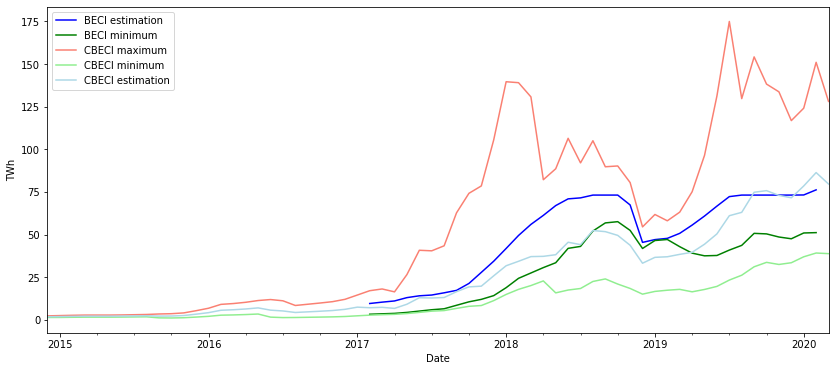

In [25]:
ax = BECI_avg.plot(figsize=(14,6), color=['blue', 'green'])
CBECI_avg.plot(ax=ax, color=['salmon','lightgreen','lightblue'])
plt.ylabel('TWh')
plt.show()

## Detailed investigation of found data

In [75]:
found_missing_difficulty

,#,market_cap,price,tag,algorithm,block_time,difficulty,nethash_scraped,block_reward,exchange_rate,exchange_rate_curr,difficulty_factor,hardware_hashrate,hardware_consumption,nethash_calc,num_hardware,energy_per_second,annual_energy
Name,,,,,,,,,,,,,,,,,,
bitcoin,1,112637095947,"$6,157.28",BTC,SHA-256,628.0000,1.391252e+13,9.514942e+19,12.681600,6.122690e+03,BTC,4294967296,16000000000000,1280,9.514942e+19,5.946839e+06,7.611954e+09,6.668071e+13
ethereum,2,14302393217,$129.67,ETH,Ethash,13.2139,2.241400e+15,1.696244e+14,2.000000,2.106649e-02,BTC,1,190000000,800,1.696244e+14,8.927599e+05,7.142079e+08,6.256462e+12
bitcoinsv,4,2858475679,$155.74,BSV,SHA-256,585.0000,3.485503e+11,2.558995e+18,12.500000,2.532000e-02,BTC,4294967296,16000000000000,1280,2.558995e+18,1.599372e+05,2.047196e+08,1.793344e+12
litecoin,5,2474367059,$38.43,LTC,Scrypt,140.0000,4.894266e+06,1.501480e+14,12.500000,6.252700e-03,BTC,4294967296,504000000,970,1.501480e+14,2.979126e+05,2.889752e+08,2.531423e+12
monero,6,804523074,$45.97,XMR,RandomX,110.0000,1.578298e+11,1.434817e+09,1.801793,7.469000e-03,BTC,1,0,0,1.434817e+09,0.000000e+00,0.000000e+00,0.000000e+00
dash,9,603611050,$64.17,DASH,X11,158.0000,1.529665e+08,4.158139e+15,1.553313,1.045151e-02,BTC,1048576,0,0,1.015171e+12,0.000000e+00,0.000000e+00,0.000000e+00
ethereumclassic,10,582962764,$5.01,ETC,Ethash,13.0344,1.307509e+14,1.003122e+13,3.104000,8.164000e-04,BTC,1,190000000,800,1.003122e+13,5.279588e+04,4.223671e+07,3.699935e+11
zcash,11,287010833,$29.89,ZEC,Equihash,75.0000,4.411493e+07,4.818527e+09,5.000000,4.852330e-03,BTC,8192,42000,760,4.818527e+09,1.147268e+05,8.719239e+07,7.638054e+11
dogecoin,12,219346198,$0.001770,DOGE,Scrypt,62.0000,2.369565e+06,1.641485e+14,10000.000000,2.887500e-07,BTC,1048576,504000000,970,4.007531e+10,7.951450e+01,7.712907e+04,6.756506e+08


In [76]:
found_missing_difficulty['algorithm'].value_counts()

SHA-256      4
Equihash     3
Ethash       2
Scrypt       2
RandomX      1
X16Rv2       1
X11          1
Lyra2REv2    1
Name: algorithm, dtype: int64